# **Setup**


In [2]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 5.6MB/s 


In [3]:
import pydicom as pdm
import skimage as sk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2

from skimage.transform import resize
from skimage.io import imread
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
# drive.flush_and_unmount()
os.chdir("/content/gdrive/My Drive/Colab Notebooks/data")
os.getcwd()

Mounted at /content/gdrive


'/content/gdrive/My Drive/Colab Notebooks/data'

# **Part 1: Working with image files**
*   Load DICOM or PNG file.
*   Resize the image to user-specified dimensions (e.g. 229 x 229).
*   Write the resized image to numpy .npy files.
*   Combine the .npy files with breast density information. Store this into numpyz .npz files.



In [5]:
def resize_image(filepath, custom_shape, verbose=False):
  assert os.path.exists(filepath), "ERROR: file " + filepath + " not found!"

  if filepath.endswith(".png"):
    png_ndarray = imread(filepath)
    print_msg("Resizing PNG file...", verbose)
    png_resized = resize(image=png_ndarray, output_shape=custom_shape, anti_aliasing=False)
    print_msg("Success.", verbose)
    return (png_ndarray, png_resized)

  else:
    print_msg("Reading DICOM file...", verbose)
    dicom_dataset = pdm.dcmread(fp=filepath, defer_size=None, force=True)
    if not filepath.endswith("dcm"):
      print_msg("Decompressing DICOM file...", verbose)
      dicom_dataset = dicom_dataset.decompress()
    dicom_ndarray = dicom_dataset.pixel_array
    # plt.imshow(dicom_ndarray, cmap=plt.cm.gray)
    # plt.show()
    print_msg("Success.", verbose)

    print_msg("Resizing DICOM file...", verbose)
    dicom_resized = resize(image=dicom_ndarray, output_shape=custom_shape, anti_aliasing=False)
    print_msg("Success.", verbose) 
    # plt.imshow(dicom_resized, cmap=plt.cm.gray)
    # plt.show()

    return (dicom_dataset, dicom_resized)

In [6]:
def save_to_npy(save_to, arr_data, verbose=False):
  print_msg("Saving to npy file...", verbose)
  npy_path = save_to + ".npy"
  np.save(npy_path, arr_data)
  print_msg("Success.", verbose)
  return npy_path

In [7]:
def save_to_npz(save_to, read_from, breast_density, verbose=False):
  print_msg("Loading npy file " + read_from + "...", verbose)
  resized_arr = np.load(file=read_from, allow_pickle=False)
  num_rows, num_cols = resized_arr.shape
  print_msg("Success.", verbose)

  print_msg("Creating new data with breast_density ...", verbose)
  new_arr = np.zeros((num_rows + 1, num_cols))
  for i in range(num_rows):
    new_arr[i] = resized_arr[i,:]
  new_arr[num_rows] = np.full(shape=(num_cols,), fill_value=breast_density)
  print_msg("Success.", verbose)

  npz_path = save_to + ".npz"
  print_msg("Saving to npz file " + npz_path + "...", verbose)
  np.savez(npz_path, new_arr)
  print_msg("Success.", verbose)

  return npz_path

In [8]:
def get_patient_id(filepath):
  i = filepath.index("P_") + 2
  patient_id = "P_"
  while filepath[i].isnumeric():
    patient_id += filepath[i]
    i += 1
  print("patient id is " + patient_id)
  return patient_id

In [9]:
def get_breast_density(df, patient_id):
  breast_density = df.loc[patient_id, "breast_density"]
  if breast_density.size > 1:
    breast_density = breast_density[0]
  return breast_density

In [10]:
def get_image_files(dir_path):
  print("getting image files...")
  train_files = {}
  test_files = {}
  for root, dirs, files in os.walk(dir_path):
    if files and files[0].endswith(".dcm"):
      if "Training" in root:
        train_files[root] = files[0]
      elif "Test" in root:
        test_files[root] = files[0]
  print("done getting image files!")
  return (train_files, test_files)

In [11]:
def get_scan_type(filepath):
  scan_type = "LEFT_" if "LEFT_" in filepath else "RIGHT_"
  scan_type += "CC" if "CC" in filepath else "MLO"
  return scan_type

In [12]:
def print_msg(msg, verbose):
  if verbose:
    print(msg)

In [13]:
def sort_npy_npz_files(dir):
  npy_dir = os.path.join(dir, "npy files")
  if not os.path.exists(npy_dir):
    os.mkdir(npy_dir)
  npz_dir = os.path.join(dir, "npz files")
  if not os.path.exists(npz_dir):
    os.mkdir(npz_dir)
  for f in os.listdir(dir):
    if f.endswith(".npy"):
      os.rename(os.path.join(dir, f), os.path.join(dir, npy_dir, f))
    elif f.endswith(".npz"):
      os.rename(os.path.join(dir, f), os.path.join(dir, npz_dir, f))

In [14]:
def main_helper(files_dict, df, resize_shape=(229, 229), save=True, verbose=False):
  
  data = []
  labels = []

  for fpath in files_dict:
    patient_id = get_patient_id(fpath)
    scan_type = get_scan_type(fpath)
    breast_density = get_breast_density(df, patient_id)
    image_fp = files_dict[fpath]

    dataset, resized_ndarray = resize_image(filepath=os.path.join(fpath, image_fp), custom_shape=resize_shape, verbose=verbose)
    np_path = os.path.join(os.getcwd(), patient_id + "_" + scan_type)
    npy_path = save_to_npy(save_to=np_path, arr_data=resized_ndarray, verbose=verbose)
    npz_path = save_to_npz(save_to=np_path, read_from=npy_path, breast_density=breast_density)
    sort_npy_npz_files(os.getcwd())

    data.append(resized_ndarray)
    labels.append(0 if breast_density <= 2 else 1) # not dense for 1, 2 ; dense for 3, 4

  return (data, labels)

In [15]:
def main(dir_path, resize_shape=(229, 229), save=True, verbose=False):
  train_csv = os.path.join(os.getcwd(), "mass_case_description_train_set.csv")
  test_csv = os.path.join(os.getcwd(), "mass_case_description_test_set.csv")
  train_df = pd.read_csv(train_csv, index_col="patient_id")
  test_df = pd.read_csv(test_csv, index_col="patient_id")

  train_files, test_files = get_image_files(dir_path)

  train_data, train_labels = main_helper(train_files, train_df, resize_shape, save, verbose)
  test_data, test_labels = main_helper(test_files, test_df, resize_shape, save, verbose)
  return (train_data, train_labels, test_data, test_labels)

# **Testing**

In [16]:
dir_path = os.getcwd()
train_validation_data, train_validation_labels, test_data, test_labels = main(dir_path, verbose=False)

getting image files...
done getting image files!
patient id is P_00229
patient id is P_00058
patient id is P_00187
patient id is P_00304
patient id is P_00247
patient id is P_00045
patient id is P_00160
patient id is P_00055
patient id is P_00351
patient id is P_00044
patient id is P_00068
patient id is P_00330
patient id is P_00376
patient id is P_00224
patient id is P_00242
patient id is P_00396
patient id is P_00134
patient id is P_00208
patient id is P_00264
patient id is P_00348
patient id is P_00303
patient id is P_00027
patient id is P_00080
patient id is P_00094
patient id is P_00289
patient id is P_00235
patient id is P_00283
patient id is P_00294
patient id is P_00207
patient id is P_00120
patient id is P_00224
patient id is P_00231
patient id is P_00205
patient id is P_00313
patient id is P_00298
patient id is P_00190
patient id is P_00332
patient id is P_00001
patient id is P_00039
patient id is P_00175
patient id is P_00021
patient id is P_00092
patient id is P_00289
patie

# **Part 2: Machine Learning**

**Partitioning Data**

In [17]:
data = np.asarray(train_validation_data)
print(data.shape)

(250, 229, 229)


In [18]:
labels = np.asarray(train_validation_labels)
print(labels.shape)

(250,)


In [19]:
test_data = np.asarray(test_data)
print(test_data.shape)

(168, 229, 229)


In [20]:
test_labels = np.asarray(test_labels)
print(test_labels.shape)

(168,)


In [21]:
train_data = data[:200, :, :]
train_labels = labels[:200]
num_train_high_density = np.count_nonzero(train_labels)
print("train data shape: ", train_data.shape)
print("train labels shape: ", train_labels.shape)
print("low density: ", len(train_labels) - num_train_high_density)
print("high density: ", num_train_high_density)
print("===================")

validation_data = data[200:, :, :]
validation_labels = labels[200:]
num_validation_high_density = np.count_nonzero(validation_labels)
print("validation data shape: ", validation_data.shape)
print("validation labels shape: ", validation_labels.shape)
print("low density: ", len(validation_labels) - num_validation_high_density)
print("high density: ", num_validation_high_density)
print("===================")

num_test_high_density = np.count_nonzero(test_labels)
print("test data shape: ", test_data.shape)
print("test labels shape: ", test_labels.shape)
print("low density: ", len(test_labels) - num_test_high_density)
print("high density: ", num_test_high_density)

train data shape:  (200, 229, 229)
train labels shape:  (200,)
low density:  134
high density:  66
validation data shape:  (50, 229, 229)
validation labels shape:  (50,)
low density:  31
high density:  19
test data shape:  (168, 229, 229)
test labels shape:  (168,)
low density:  99
high density:  69


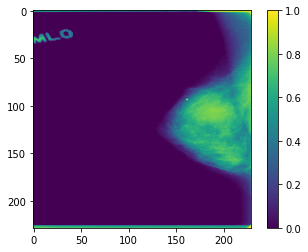

In [24]:
index = np.random.randint(low=0, high=len(train_data))
plt.figure()
plt.imshow(train_data[index])
plt.colorbar()
plt.grid(False)
plt.show()

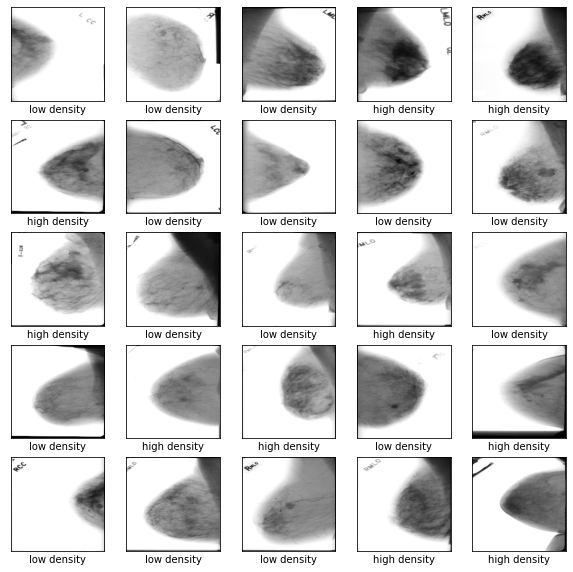

In [25]:
# Citation: https://www.tensorflow.org/tutorials/keras/classification
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[i], cmap=plt.cm.binary)
    if train_labels[i] == 0:
      plt.xlabel("low density")
    else:
      plt.xlabel("high density")
plt.show()

**Setting Up Model**

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data, validation_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

In [27]:
batch_size = 25                                                                    # ideal: 32, 64
shuffle_buffer_size = 10
train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
validation_dataset = validation_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

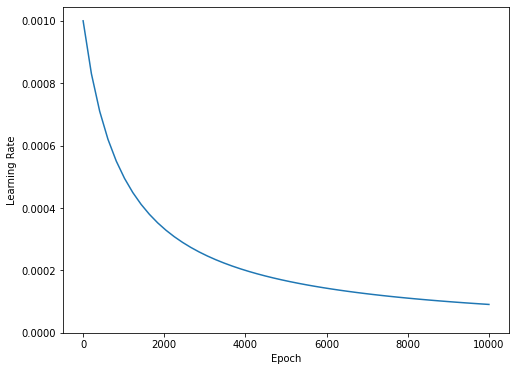

In [28]:
# Citation: from tensorflow.org
steps_per_epoch = 250/batch_size

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
                    0.001, #increase
                    decay_steps=steps_per_epoch*1000, # smaller steps
                    decay_rate=1,
                    staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/steps_per_epoch, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [29]:
model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(229,229)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(2)
])

**Training and Testing Model**

In [30]:
model.compile(optimizer=get_optimizer(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

In [31]:
model.fit(x=train_data, y=train_labels, epochs=30, validation_data=validation_dataset, validation_steps=30)

Epoch 1/30
7/7 [==============================] - 0s 67ms/step - loss: 2.2831 - sparse_categorical_accuracy: 0.5450 - val_loss: 1.1537 - val_sparse_categorical_accuracy: 0.5400
Epoch 2/30
7/7 [==============================] - 0s 35ms/step - loss: 0.9674 - sparse_categorical_accuracy: 0.5700
Epoch 3/30
7/7 [==============================] - 0s 37ms/step - loss: 0.9826 - sparse_categorical_accuracy: 0.5850
Epoch 4/30
7/7 [==============================] - 0s 34ms/step - loss: 0.7138 - sparse_categorical_accuracy: 0.7200
Epoch 5/30
7/7 [==============================] - 0s 34ms/step - loss: 0.8393 - sparse_categorical_accuracy: 0.6450
Epoch 6/30
7/7 [==============================] - 0s 37ms/step - loss: 0.5207 - sparse_categorical_accuracy: 0.7250
Epoch 7/30
7/7 [==============================] - 0s 34ms/step - loss: 0.5506 - sparse_categorical_accuracy: 0.7400
Epoch 8/30
7/7 [==============================] - 0s 35ms/step - loss: 0.6089 - sparse_categorical_accuracy: 0.6850
Epoch 9/30


In [32]:
model.evaluate(x=test_data, y=test_labels, batch_size=4)
results = model.predict(test_dataset, steps=30)

print(results.shape)
print(results)

42/42 [==============================] - 0s 4ms/step - loss: 0.8195 - sparse_categorical_accuracy: 0.7202
(168, 2)
[[-1.39884830e+00  6.20476007e-01]
 [ 8.17957878e+00  2.36689305e+00]
 [ 3.90981054e+00  9.46131423e-02]
 [ 6.11980438e+00  7.10224271e-01]
 [ 9.27729130e+00  7.41035604e+00]
 [ 7.12805653e+00  1.06583385e+01]
 [ 1.41067524e+01  1.67386303e+01]
 [ 6.15844309e-01  1.76105142e-01]
 [ 1.39325504e+01  1.59244843e+01]
 [-6.78622127e-01 -3.43418032e-01]
 [ 4.63840532e+00  5.81983280e+00]
 [ 6.98991871e+00  1.04532146e+00]
 [ 1.73240204e+01  8.97303581e+00]
 [ 8.09776497e+00  9.38262844e+00]
 [ 4.25259161e+00  8.31375182e-01]
 [ 7.71229649e+00  1.03975716e+01]
 [ 1.09859018e+01  1.13422108e+01]
 [ 4.87986660e+00  9.48833752e+00]
 [ 6.75466585e+00  7.03253984e+00]
 [ 1.02355375e+01  1.08308716e+01]
 [-9.96880710e-01 -6.23623908e-01]
 [ 1.09262681e+00  1.15611754e-01]
 [ 1.17357798e+01  1.00693569e+01]
 [ 6.05577087e+00  6.50013924e+00]
 [ 1.35483208e+01  5.83413029e+00]
 [ 9.82035

**Process Test Results**

In [33]:
tf.nn.softmax(results)

<tf.Tensor: shape=(168, 2), dtype=float32, numpy=
array([[1.1718888e-01, 8.8281113e-01],
       [9.9701947e-01, 2.9804800e-03],
       [9.7844166e-01, 2.1558361e-02],
       [9.9554634e-01, 4.4535943e-03],
       [8.6610329e-01, 1.3389674e-01],
       [2.8462790e-02, 9.7153723e-01],
       [6.7114770e-02, 9.3288517e-01],
       [6.0819691e-01, 3.9180315e-01],
       [1.2005243e-01, 8.7994760e-01],
       [4.1697493e-01, 5.8302510e-01],
       [2.3479563e-01, 7.6520437e-01],
       [9.9738687e-01, 2.6131109e-03],
       [9.9976391e-01, 2.3610813e-04],
       [2.1672350e-01, 7.8327650e-01],
       [9.6836108e-01, 3.1638939e-02],
       [6.3847855e-02, 9.3615222e-01],
       [4.1185334e-01, 5.8814663e-01],
       [9.8686852e-03, 9.9013126e-01],
       [4.3097508e-01, 5.6902492e-01],
       [3.5541192e-01, 6.4458805e-01],
       [4.0775430e-01, 5.9224570e-01],
       [7.2651553e-01, 2.7348444e-01],
       [8.4109831e-01, 1.5890169e-01],
       [3.9070055e-01, 6.0929942e-01],
       [9.9955

In [34]:
predicted_densities = tf.math.argmax(input=results, axis=1)
predicted_densities

<tf.Tensor: shape=(168,), dtype=int64, numpy=
array([1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0])>

In [35]:
np_predicted = tf.make_tensor_proto(predicted_densities)  # convert `tensor a` to a proto tensor
np_predicted = tf.make_ndarray(np_predicted)
np_predicted

array([1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0])

# **Part 3: Confusion Matrix and ROC Curve**

**Confusion Matrix**

https://en.wikipedia.org/wiki/Confusion_matrix
  

```
                  actual 0        actual 1    
predicted 0   true_zero (TP)   false_zero (FP)
predicted 1   false_one (FN)   true_one (TN)  
```

In [36]:
actual = test_labels
predicted = np_predicted
true_zero = 0
true_one = 0
false_one = 0
false_zero = 0
for i in range(len(predicted)):
  if actual[i] == predicted[i]:
    if actual[i] == 0:
      true_zero += 1
    else:
      true_one += 1
  else:
    if actual[i] == 0 and predicted[i] == 1:
      false_one += 1
    else:
      false_zero += 1

In [37]:
data_dict = { "actual 0" : [true_zero, false_one], "actual 1" : [false_zero, true_one]}
confusion_matrix = pd.DataFrame(data_dict, index=["predicted 0", "predicted 1"])
confusion_matrix

,actual 0,actual 1
predicted 0,78,26
predicted 1,21,43


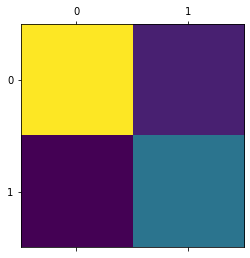

In [38]:
np_conf_matrix = confusion_matrix.to_numpy()
plt.matshow(np_conf_matrix)

**ROC Curve**
*   https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc#:~:text=An%20ROC%20curve%20

In [42]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true=test_labels, y_score=predicted, pos_label=1)
print("fpr: ", fpr)
print("tpr: ", tpr)
print("thresholds: ", thresholds)

fpr:  [0.         0.21212121 1.        ]
tpr:  [0.         0.62318841 1.        ]
thresholds:  [2 1 0]


Text(0, 0.5, 'TP Rate')

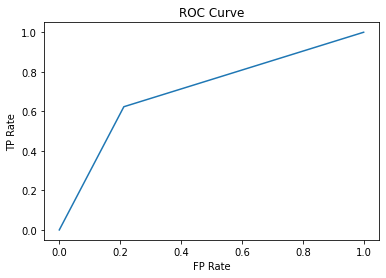

In [43]:
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")

In [44]:
auc_value = auc(fpr, tpr)
auc_value

0.7055335968379447

# **Potential Areas for Improvement**



*   Merge retrieve + process steps for each image file instead of separately retrieving all image files, then starting processing
*   Obtain more even distributions of low- and high-density images for ML
*   Use image data generator to get one file at a time (if there are too many files to retrieve all at once)





# **Appendix: Code Documentation**

**`resize_image(filepath, custom_shape, show=True, verbose=False)`**
*   Inputs 
  * FILEPATH: string path of image file to resize
  * CUSTOM_SHAPE: tuple of resized dimensions (e.g. (299, 299))
  * [SHOW=True]: plot image before and after resizing
  * [VERBOSE=False]: do not print intermediate progress
*   Outputs
  1. if DICOM, dataframe; if PNG, original image numpy array
  2. resized array
*  Functionality
  * Resizes input image file to custom dimension and returns the original dataframe or image array and the resized array. 


**`save_to_npy(filepath, arr_data, verbose=False)`**
*   Inputs
  * FILEPATH: desired numpy filepath string (no extensions)
  * ARR_DATA: numpy array to save in the numpy file
  * [VERBOSE=False]: do not print intermediate progress
*   Outputs
  1. NPY_PATH: the full numpy filepath (with .npy extension)
*   Functionality
  * Saves input data to a numpy file using the desired filepath.


**`save_to_npz(save_to, read_from, breast_density, verbose=False)`**
*   Inputs
  * SAVE_TO: desired numpyz filepath string (no extensions)
  * READ_FROM: numpy filepath containing the resized image ndarray
  * BREAST_DENSITY: integer
  * [VERBOSE=False]: do not print intermediate progress
*   Outputs
    1. NPZ_PATH: the full numpyz path (with .npz extension)
*   Functionality
  * Saves input array and breast density to a new numpyz file.

**`get_breast_density(df, patient_id)`**
*  Inputs
  * DF: dataframe from reading csv file (for breast density info)
  * PATIENT_ID: patient id (attribute of dataset from reading DICOM file)
*  Outputs
    1. breast density (integer) of input patient
*  Functionality
  * Returns the breast density corresponding to PATIENT_ID


**`main`**
*  Inputs
  * DIR: directory of image files to operate on
  * [RESIZE_SHAPE=(229, 229)]: tuple of desired resizing dimensions
  * [VERBOSE=False]: do not print intermediate progress
*  Outputs
  * 1. python array of training image pixel arrays
  * 2. python array of training labels (*i*th label corresponds to the *i*th training image pixel array)
  * 3. python array of testing image pixel arrays
  * 4. python array of testing labels (*i*th label corresponds to the *i*th training image pixel array)
*  Functionality
  * For each DICOM file in DIR,
    1. resize
    2. save to numpy file
    3. save to numpyz file with breast density information